# Language Translator
1. load the all required modules.

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Dense
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pickle

2025-11-25 13:49:44.414068: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 13:49:44.437927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-25 13:49:44.437949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 13:49:44.438863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-25 13:49:44.443058: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 13:49:44.443574: I tensorflow/core/platform/cpu_feature_guard.cc:1

2. initilize all the variables
   - input text as list
   - output/target text as list
   - imput characters as set
   - target characters as set

In [2]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
print(type(target_characters))

<class 'set'>


3. read dataset file

In [3]:
with open('eng-french.txt','r',encoding='utf-8') as f:
    rows = f.read().split('\n')

# lets read thousands of line from the file

In [4]:
for row in rows[:10000]:
    #split input and target by '\t' i.e. tab
    input_text,target_text = row.split('\t')
    #add '\t' at start and '\n' at end of text
    target_text = '\t'+target_text+ '\n'
    input_texts.append(input_text.lower())
    target_texts.append(target_text.lower())
    #split character from text and add it respective sets
    input_characters.update(list(input_text.lower()))
    target_characters.update(list(target_text.lower()))

#sort input and target characters

In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

# get the total length of input and target characters

In [6]:
num_en_chars = len(input_characters)
num_dec_chars = len(target_characters)

# get the maximum length of input and target text

In [7]:
max_input_length = max([len(i) for i in input_texts])
max_target_length = max([len(i) for i in target_texts])

In [8]:
def bagofcharacters(input_texts,target_texts):
  #inintialize encoder , decoder input and target data.
  en_in_data=[] ; dec_in_data=[] ; dec_tr_data=[]
  #padding variable with first character as 1 as rest all 0.
  pad_en=[1]+[0]*(len(input_characters)-1)
  pad_dec=[0]*(len(target_characters)) ; pad_dec[2]=1
  #countvectorizer for one hot encoding as we want to tokenize character so
  #anlyzer is true and None the stopwords action.
  cv=CountVectorizer(binary=True,tokenizer=lambda txt: txt.split(),stop_words=None,analyzer='char')
  for i,(input_t,target_t) in enumerate(zip(input_texts,target_texts)):
    #fit the input characters into the CountVectorizer function
    cv_inp= cv.fit(input_characters)
    
    #transform the input text from the help of CountVectorizer fit.
    #it character present than put 1 and 0 otherwise.
    en_in_data.append(cv_inp.transform(list(input_t)).toarray().tolist())
    cv_tar= cv.fit(target_characters)		
    dec_in_data.append(cv_tar.transform(list(target_t)).toarray().tolist())
    #decoder target will be one timestep ahead because it will not consider 
    #the first character i.e. '\t'.
    dec_tr_data.append(cv_tar.transform(list(target_t)[1:]).toarray().tolist())
    
    #add padding variable if the length of the input or target text is smaller
    #than their respective maximum input or target length. 
    if len(input_t) < max_input_length:
      for _ in range(max_input_length-len(input_t)):
        en_in_data[i].append(pad_en)
    if len(target_t) < max_target_length:
      for _ in range(max_target_length-len(target_t)):
        dec_in_data[i].append(pad_dec)
    if (len(target_t)-1) < max_target_length:
      for _ in range(max_target_length-len(target_t)+1):
        dec_tr_data[i].append(pad_dec)
      #convert list to numpy array with data type float32
  en_in_data=np.array(en_in_data,dtype="float32")
  dec_in_data=np.array(dec_in_data,dtype="float32")
  dec_tr_data=np.array(dec_tr_data,dtype="float32")

  return en_in_data,dec_in_data,dec_tr_data

In [9]:
#create input object of total number of encoder characters
en_inputs = Input(shape=(None, num_en_chars))
#create LSTM with the hidden dimension of 256
#return state=True as we don't want output sequence.
encoder = LSTM(256, return_state=True)
#discard encoder output and store hidden and cell state.
en_outputs, state_h, state_c = encoder(en_inputs)
en_states = [state_h, state_c]

2025-11-25 13:49:46.406443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-25 13:49:46.410019: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
#create input object of total number of decoder characters
dec_inputs = Input(shape=(None, num_dec_chars))
#create LSTM with the hidden dimension of 256
#return state and return sequences as we want output sequence.
dec_lstm = LSTM(256, return_sequences=True, return_state=True)
#initialize the decoder model with the states on encoder.
dec_outputs, _, _ = dec_lstm(dec_inputs, initial_state=en_states)
#Output layer with shape of total number of decoder characters 
dec_dense = Dense(num_dec_chars, activation="softmax")
dec_outputs = dec_dense(dec_outputs)

In [11]:
#create Model and store all variables 
model = Model([en_inputs, dec_inputs], dec_outputs)
pickle.dump({'input_characters':input_characters,'target_characters':target_characters,
             'max_input_length':max_input_length,'max_target_length':max_target_length,
             'num_en_chars':num_en_chars,'num_dec_chars':num_dec_chars},open("training_data.pkl","wb"))

In [12]:
#load the data and train the model
en_in_data,dec_in_data,dec_tr_data = bagofcharacters(input_texts,target_texts)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

/home/mrityunjay/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/mrityunjay/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [13]:
model.fit(
    [en_in_data, dec_in_data],
    dec_tr_data,
    batch_size=64,
    epochs=200,
    validation_split=0.2,
)

Epoch 1/200
125/125 [==============================] - 9s 58ms/step - loss: 1.2919 - accuracy: 0.7178 - val_loss: 1.1233 - val_accuracy: 0.6869
Epoch 2/200
125/125 [==============================] - 7s 54ms/step - loss: 0.8984 - accuracy: 0.7509 - val_loss: 0.9743 - val_accuracy: 0.7327
Epoch 3/200
125/125 [==============================] - 7s 54ms/step - loss: 0.7544 - accuracy: 0.7922 - val_loss: 0.8246 - val_accuracy: 0.7664
Epoch 4/200
125/125 [==============================] - 7s 54ms/step - loss: 0.6536 - accuracy: 0.8128 - val_loss: 0.7419 - val_accuracy: 0.7855
Epoch 5/200
125/125 [==============================] - 7s 53ms/step - loss: 0.5948 - accuracy: 0.8272 - val_loss: 0.6984 - val_accuracy: 0.7932
Epoch 6/200
125/125 [==============================] - 7s 54ms/step - loss: 0.5579 - accuracy: 0.8369 - val_loss: 0.6633 - val_accuracy: 0.8046
Epoch 7/200
125/125 [==============================] - 7s 54ms/step - loss: 0.5301 - accuracy: 0.8446 - val_loss: 0.6457 - val_accuracy:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 47)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 67)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                311296    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

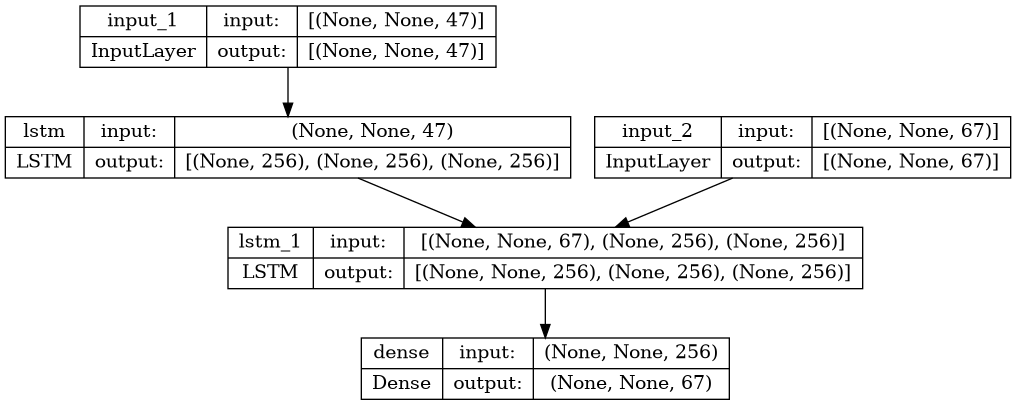

In [14]:
#summary and model plot
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
# Save model
model.save("s2s")


INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets
